
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [1]:
# # The next 8 lines added to be compatible with version changes (2022/10/13).
# # change cuda to 11.1
# import os
# p = os.getenv('PATH')
# ld = os.getenv('LD_LIBRARY_PATH')
# os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
# os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# # change pytorch to 1.9.0 compiled with cuda 11.1
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# # install dependencies:
# !pip install pyyaml==5.1 pycocotools>=2.0.1
# # !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

In [2]:
# !pwd # shows current directory
# !ls  # shows all files in this directory
# !nvidia-smi # shows the specs and the current status of the allocated GPU

In [3]:
# import some common libraries
# from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
setup_logger()

import imagesize
from glob import glob 
import matplotlib.pyplot as plt

In [4]:
# Make sure that GPU is available for your notebook.
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

True

In [5]:
# # You need to mount your google drive in order to load the data:
# from google.colab import drive
# drive.mount('/content/drive')
# # Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# # Also create an output directory for your files such as the trained models and the output images.

In [6]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '.'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_OF_WORKER = 8
IMAGE_DIR = "{}/images".format(BASE_DIR)
os.makedirs(IMAGE_DIR, exist_ok=True)

COCO_EVALUATOR_OUTPUT = "{}/coco_output".format(BASE_DIR)
os.makedirs(COCO_EVALUATOR_OUTPUT, exist_ok=True)

## Part 1: Object Detection

### Data Loader

In [7]:
'''
# This function should return a list of data samples in which each sample is a dictionary.
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''

TEST_DATA_RATIO = 0.8

def get_all_images_name(json_data):
  return list(set([x['file_name'] for x in json_data]))

def get_detection_test_data():
  dataset = []
  test_imgs = glob(BASE_DIR + "/data/test/*.png")
  
  for idx, img in enumerate(test_imgs):
    record = {}
    # Using cv2 to read size is too slow
    width, height = imagesize.get(img)
    
    record['file_name'] = img
    record['image_id'] = idx
    record['height'] = height
    record['width'] = width
    record['annotations'] = []
    
    dataset.append(record)
  
  return dataset

def get_detection_data(set_name):
  if set_name not in ["train", "val", "test", "all_train"]:
    assert("Set name unknown")
    
  if set_name == "test":
    return get_detection_test_data()
      
  dataset = []
  
  with open(BASE_DIR + "/data/train.json") as f:
    imgs_anns = json.load(f)
    imgs_anns = sorted(imgs_anns, key=lambda x: x["file_name"])
    
  np.random.seed(762)
  imgs_name = get_all_images_name(imgs_anns)
  test_imgs = np.random.choice(imgs_name, int(len(imgs_name) * TEST_DATA_RATIO), replace=False)
  val_imgs = [x for x in imgs_name if x not in test_imgs]
    
  idx = 0
  while idx < len(imgs_anns):
    record = {}
    
    if set_name == "train":
      if imgs_anns[idx]["file_name"] not in test_imgs:
        idx += 1
        continue
    elif set_name == "val":
      if imgs_anns[idx]["file_name"] not in val_imgs:
        idx += 1
        continue
    else:
      # Load all train data for pred.csv generation
      pass

    # Using cv2 to read size is too slow
    width, height = imagesize.get(BASE_DIR + "/data/train/" + imgs_anns[idx]["file_name"])
    
    record['file_name'] = BASE_DIR + "/data/train/" + imgs_anns[idx]["file_name"]
    record['image_id'] = imgs_anns[idx]["image_id"]
    record['height'] = height
    record['width'] = width
    record['annotations'] = []
  
    while idx < len(imgs_anns) and record['file_name'].split('/')[-1] == imgs_anns[idx]["file_name"]:
      record['annotations'].append({
        "bbox": imgs_anns[idx]['bbox'],
        "bbox_mode": BoxMode.XYWH_ABS,
        "segmentation": imgs_anns[idx]["segmentation"],
        "category_id": 0
      })
      idx += 1
      
    dataset.append(record)
    
  return dataset

In [8]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''

for d in ["train", "val", "test", "all_train"]:
  DatasetCatalog.register("data_detection_" + d, lambda d=d: get_detection_data(d))
  MetadataCatalog.get("data_detection_" + d).set(thing_classes=["plane"])

In [9]:
# '''
# # Visualize some samples using Visualizer to make sure that the function works correctly
# # TODO: approx 5 lines
# '''

# dataset_dicts = get_detection_data("train")
# for idx, d in enumerate(random.sample(dataset_dicts, 3)):
#   img = cv2.imread(d["file_name"])
#   visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("data_detection_train"), scale=0.5)
#   out = visualizer.draw_dataset_dict(d)
#   cv2.imwrite('{}/{}.png'.format(IMAGE_DIR, idx), out.get_image()[:, :, ::-1])

### Set Configs

In [10]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = OUTPUT_DIR
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train",)
cfg.DATALOADER.NUM_WORKERS = NUM_OF_WORKER
cfg.SOLVER.MAX_ITER = 1200
cfg.SOLVER.BATCH_SIZE_PER_IMAGE = 512
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
# disable the evaluation
cfg.DATASETS.TEST = ()

### Training

In [11]:
# '''
# # Create a DefaultTrainer using the above config and train the model
# # TODO: approx 5 lines
# '''

# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

### Evaluation and Visualization

In [12]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''

cfg.MODEL.WEIGHTS = OUTPUT_DIR + "/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6

obj_detect_model = DefaultPredictor(cfg)

[10/22 02:24:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [13]:
# '''
# # Visualize the output for 3 random test samples
# # TODO: approx 10 lines
# '''

# dataset_dicts = get_detection_data("val")
# for idx, d in enumerate(random.sample(dataset_dicts, 3)):
#   img = cv2.imread(d["file_name"])
#   output = obj_detect_model(img)
#   visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("data_detection_train"), scale=0.5)
#   out = visualizer.draw_instance_predictions(output['instances'].to("cpu"))
#   cv2.imwrite('{}/Visualize_part1_{}.png'.format(IMAGE_DIR, idx), out.get_image()[:, :, ::-1])

In [14]:
# '''
# # Use COCOEvaluator and build_detection_train_loader
# # You can save the output predictions using inference_on_dataset
# # TODO: approx 5 lines
# '''

# evaluator = COCOEvaluator("data_detection_val", cfg, False, output_dir=COCO_EVALUATOR_OUTPUT, allow_cached_coco=False)

# val_loader = build_detection_test_loader(cfg, "data_detection_val")

# # clean file to avoid Error "Results do not correspond to current coco set"
# os.system("rm -f {}/*".format(COCO_EVALUATOR_OUTPUT))

# inference_on_dataset(obj_detect_model.model, val_loader, evaluator)


### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [15]:
'''
# Bring any changes and updates regarding the improvement in here
'''


'\n# Bring any changes and updates regarding the improvement in here\n'

## Part 2: Semantic Segmentation

### Data Loader

In [16]:
IMAGE_SIZE = 128

'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import GenericMask

def get_instance_sample(data, idx, img=None):
  img = cv2.imread(data['file_name'])
  height = data['height']
  width = data['width']
  bbox = data['annotations'][idx]['bbox']
  x1 = int(bbox[0])
  x2 = int(bbox[0] + bbox[2])
  y1 = int(bbox[1])
  y2 = int(bbox[1] + bbox[3])
  
  crop_img = img[y1:y2, x1:x2]
  
  mask = GenericMask(data['annotations'][idx]['segmentation'], height, width).mask
  crop_mask = mask[y1:y2, x1:x2]
  
  obj_img = cv2.resize(crop_img, (IMAGE_SIZE, IMAGE_SIZE))
  obj_mask = cv2.resize(crop_mask, (IMAGE_SIZE, IMAGE_SIZE))
  
  return obj_img, obj_mask

In [17]:
# # test get_instance_sample()

# import matplotlib.pyplot as plt

# test_tar = get_detection_data("train")[0]

# obj_img, obj_mask = get_instance_sample(test_tar, 4)

# plt.imshow(obj_img)
# plt.savefig("obj_img.png")

# plt.cla()
# plt.imshow(obj_mask)
# plt.savefig("obj_mask.png")

# print(test_tar['file_name'])

In [18]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
    img = torch.tensor(img, dtype=torch.float)
    mask = torch.tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
        
    # idx[0, 1]: idx[0] is  the index for image, idx[1] is 
    # the index for annotations
    idx = self.instance_map[idx]
    data = self.data[idx[0]]

    img, mask = get_instance_sample(data, idx[1])
    
    return self.numpy_to_tensor(img, mask)

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                              pin_memory=True, shuffle=True)
    return loader, dataset

### Network

In [19]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)
             )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Encoder

        self.input_conv = conv(3, 4)
        self.down = down(4, 8)

        # Decoder

        self.up = up(8, 4)
        self.output_conv = conv(4, 1, False) # ReLu activation is removed to keep the logits for the loss function


    def forward(self, input):
      y = self.input_conv(input)
      y = self.down(y)
      y = self.up(y)
      output = self.output_conv(y)
      return output

### Training

In [20]:
# '''
# # The following is a basic training procedure to train the network
# # You need to update the code to get the best performance
# # TODO: approx ? lines
# '''

# # Set the hyperparameters
# num_epochs = 5
# batch_size = 4
# learning_rate = 0.01
# weight_decay = 1e-5

# model = MyModel() # initialize the model
# model = model.cuda() # move the model to GPU
# loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
# crit = nn.BCEWithLogitsLoss() # Define the loss function
# optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD

# # start the training procedure
# for epoch in range(num_epochs):
#   total_loss = 0
#   for (img, mask) in tqdm(loader):
#     img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
#     mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)
    
#     # mannally correct the shape
#     mask = torch.squeeze(mask)
    
#     pred = model(img)
#     loss = crit(pred, mask)
#     optim.zero_grad()
#     loss.backward()
#     optim.step()
#     total_loss += loss.cpu().data
#   print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(loader)))
#   torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))

# '''
# # Saving the final model
# '''
# torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


### Evaluation and Visualization

In [21]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''

# load model and data
batch_size = 8
seg_model = MyModel().cuda()
seg_model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
seg_model = seg_model.eval() # chaning the model to evaluation mode will fix the bachnorm layers
loader, dataset = get_plane_dataset('val', batch_size)

In [22]:
# # evaluation

# total_iou = 0
# images = 0
# for (img, mask) in tqdm(loader):
#   with torch.no_grad():
#     img = img.cuda()
#     mask = mask.cuda()
#     mask = torch.unsqueeze(mask,1)
#     pred = seg_model(img)
    
#     sigmoid = nn.Sigmoid()
#     sig_pred = sigmoid(pred)
#     sig_pred[sig_pred >= 0.5] = 1
#     sig_pred[sig_pred < 0.5] = 0

#     intersection = torch.sum(torch.logical_and(mask, sig_pred))
#     union = torch.sum(torch.logical_or(mask, sig_pred))
    
#     if union != 0:
#       total_iou += intersection / union
#     '''
#     ## Complete the code by obtaining the IoU for each img and print the final Mean IoU
#     '''
#   images += 1


# print("\n #images: {}, Mean IoU: {}".format(images, total_iou / images))

In [23]:
# '''
# # Visualize 3 sample outputs
# # TODO: approx 5 lines
# '''

# img_path = IMAGE_DIR + "/manually_cropped/*"
# imgs = glob(img_path)

# for idx, img_path in enumerate(imgs):
#   img = cv2.imread(img_path)
#   img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
#   trans2tensor = transforms.ToTensor()
#   img = trans2tensor(img)
#   img = torch.tensor(img, dtype=torch.float)
#   img = img.reshape((1, 3, IMAGE_SIZE, IMAGE_SIZE))

#   with torch.no_grad():
#     img = img.cuda()
#     pred = seg_model(img)
    
#     sigmoid = nn.Sigmoid()
#     sig_pred = sigmoid(pred)
#     sig_pred[sig_pred >= 0.5] = 1
#     sig_pred[sig_pred < 0.5] = 0
    
#     img = np.transpose(img.cpu(), (3, 2, 1, 0))
#     img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 3))
    
#     sig_pred = np.transpose(sig_pred.cpu(), (3, 2, 1, 0))
#     sig_pred = np.reshape(sig_pred, (IMAGE_SIZE, IMAGE_SIZE, 1))
  
#     plt.cla()
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(img)
#     ax[1].imshow(sig_pred, cmap='gray', vmin=0, vmax=1)
    
#     plt.savefig(IMAGE_DIR + "/Visualize_part2_{}.png".format(idx))

## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [24]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# It is better to keep everything (as well as the output of this funcion) on gpu as tensors to speed up the operations.
# pred_mask is the instance segmentation result and should have different values for different planes.
# TODO: approx 35 lines
'''
from detectron2.structures.boxes import pairwise_point_box_distance

def remove_overlapped_bbox(instances, score_threshold=0.8):
  removed_idx = []
  num_of_ins = len(instances['instances'])
  for i in range(num_of_ins):
    if i in removed_idx:
      continue
    for j in range(i + 1, num_of_ins):
      if j in removed_idx:
        continue
      
      dis1 = pairwise_point_box_distance(instances['instances'][i].pred_boxes.get_centers(),
                                         instances['instances'][j].pred_boxes)
      dis2 = pairwise_point_box_distance(instances['instances'][j].pred_boxes.get_centers(),
                                        instances['instances'][i].pred_boxes)
      
      # i is in j or j is in i
      if torch.all(dis1 > 0).item() or torch.all(dis2 > 0).item():
        if instances['instances'][i].scores.item() > instances['instances'][j].scores.item():
          removed_idx.append(j)
        else:
          removed_idx.append(i)

  # Create new instances with overlapped bbox removed
  height, width = instances['instances'].image_size
  
  kept_idx = [x for x in range(len(instances['instances'])) if x not in removed_idx]
  new_instances = detectron2.structures.Instances(image_size=(height, width))
          
  classes = instances['instances'].pred_classes[kept_idx]
  scores = instances['instances'].scores[kept_idx]
  boxes = instances['instances'].pred_boxes[kept_idx]
  
  new_instances.set('pred_classes', classes)
  new_instances.set('scores', scores)
  new_instances.set('pred_boxes', boxes)
  
  # Remove low score bbox
  new_instances = new_instances[new_instances.scores >= score_threshold]        
  
  return {"instances": new_instances}

def get_prediction_mask(data):
  img = cv2.imread(data['file_name'])
  height, width = img.shape[:2]
  
  obj_detect_result = obj_detect_model(img)
  
  obj_detect_result = remove_overlapped_bbox(obj_detect_result)
  
  pred_mask = np.zeros((height,width), np.uint8)
  
  num_of_bbox = len(obj_detect_result['instances'])
  for idx in range(num_of_bbox):
    # Obtain the bbox from Instances
    x0, y0, x1, y1 = [int(x) for x in obj_detect_result['instances'][idx].pred_boxes.tensor.cpu().numpy()[0]]
    crop_img = img[y0:y1, x0:x1]
    ori_h, ori_w = crop_img.shape[:2]
    obj_img = cv2.resize(crop_img, (IMAGE_SIZE, IMAGE_SIZE))
    
    # convert obj_img to suitable format
    trans2tensor = transforms.ToTensor()
    obj_img = trans2tensor(obj_img)
    obj_img = obj_img.reshape((1, 3, IMAGE_SIZE, IMAGE_SIZE))

    with torch.no_grad():
      obj_img = obj_img.cuda()
      pred = seg_model(obj_img)
      
      sigmoid = nn.Sigmoid()
      sig_pred = sigmoid(pred)
      
      sig_pred[sig_pred >= 0.5] = idx + 1
      sig_pred[sig_pred < 0.5] = 0
            
      sig_pred = np.transpose(sig_pred.cpu(), (2, 3, 0, 1))
      sig_pred = np.reshape(sig_pred, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Resize the colored_pred to original size, and update the pred_mask
    sig_pred = cv2.resize(sig_pred.numpy(), (ori_w, ori_h))
    pred_mask[y0:y1, x0:x1] = sig_pred
  
  gt_mask = None
  img = torch.tensor(img, device='cuda')
  # gt_mask = torch.tensor(gt_mask)
  pred_mask = torch.tensor(pred_mask, device='cuda')
  
  return img, gt_mask, pred_mask # gt_mask could be all zero when the ground truth is not given.


### Visualization and Submission

./data/test/P0841.png


Num of mask: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23], device='cuda:0', dtype=torch.uint8)


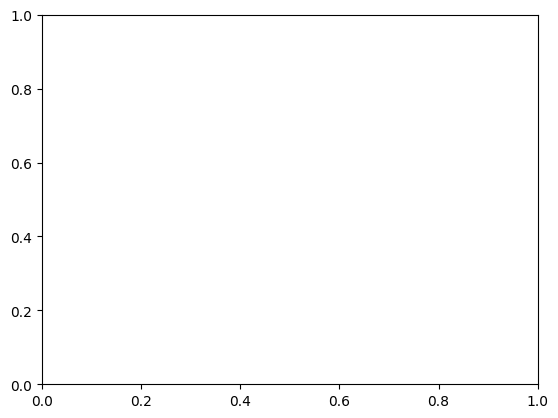

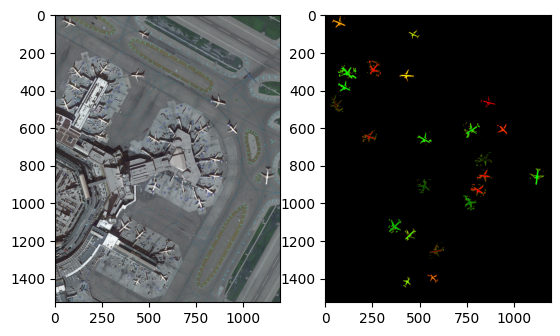

In [47]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''
# The getDistinctColors function is from https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python
import colorsys 
 
def HSVToRGB(h, s, v): 
 (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
 return [int(255*r), int(255*g), int(255*b)]
 
def getDistinctColors(n): 
 huePartition = 1.0 / (n + 1) 
 return [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n)]

visual_id = 17

# Test get_prediction_mask
print(get_detection_data("test")[visual_id]['file_name'])
img, gt_mask, pred_mask = get_prediction_mask(get_detection_data("test")[visual_id])

print("Num of mask: {}".format(torch.unique(pred_mask)))

# convert the gray scale mask to a colored mask
colored_pred = torch.zeros([pred_mask.shape[0], pred_mask.shape[1], 3])
num_of_bbox = torch.max(pred_mask).cpu().item()
distinct_colors = getDistinctColors(num_of_bbox)
# print(distinct_colors)
for rgb in range(2):
  for idx in range(1, num_of_bbox + 1):
    colored_pred[:, :, rgb][pred_mask == idx] = distinct_colors[idx - 1][rgb]

img = cv2.resize(img.cpu().numpy(), (0, 0), fx=0.5, fy=0.5)
pred_mask = cv2.resize(colored_pred.cpu().numpy(), (0, 0), fx=0.5, fy=0.5)

pred_mask = pred_mask.astype('int')

plt.cla()
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(pred_mask)

plt.savefig("temp.png")


In [ ]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [ ]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("data_detection_{}".format('all_train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

### Network

### Training

### Evaluation and Visualization